In [9]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import random
from IPython.core.display import HTML
import shutil
import re

CONV_DROPOUT_P = 0.6
FC_DROPOUT_P = 0.6
OBJECTIVE_NAME = 'voice_cmd'

def make_identifier_regex(name):
    return f"(?P<{name}>[a-zA-Z0-9\-\_]+)"


def make_number_regex(name):
    return f"(?P<{name}>[0-9\.]+)"



RESULT_FILE_REGEX = re.compile(
    f"{make_identifier_regex('model_name')}__c_dropout_p_{CONV_DROPOUT_P}__f_dropout_p_{FC_DROPOUT_P}__feature_{make_identifier_regex('feature_name')}__fold_id_{make_number_regex('fold_id')}__obj_{OBJECTIVE_NAME}"
)

model_names = [
    "VAASRCNN3PoolAvgAggMax",
    "VAASRCNN3PoolMaxAggMax"
]

    

DATA_DIR = "results_106/"


random.seed(42)
# COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
COLORS = ["#7f7f7f", "#1f77b4", "#2ca02c"]

n = 0
n_train = int(np.ceil(n * .6))
n_test = n - n_train


In [10]:
data_frames = {}

variable_names = []

for result_path in Path(DATA_DIR).iterdir():
    
    match = RESULT_FILE_REGEX.match(result_path.stem)
    if not match:
        print(f"ignoring result file: {result_path}")
        continue
    
    trial_params = match.groupdict()
    
    model_name = trial_params['model_name']
    feature_name = trial_params['feature_name']
    fold_id = int(trial_params['fold_id'])
    
        
    fold_names = []
    
    if not model_name in data_frames:
        data_frames[model_name] = {}
        
    
    fold_name = f"{feature_name}_{fold_id}"
    data_frames[model_name][fold_name] = pd.read_csv(result_path)
    variable_names.extend(list(data_frames[model_name][fold_name].columns))
    
    
    
    #for p in Path(model_path).iterdir():
    #    if not p.suffixes or p.suffixes[-1] != '.csv':
    #        continue
    #    fold_name = p.stem
    #    fold_names.append(fold_name)
    #    data_frames[model_name][fold_name] = pd.read_csv(p)
    #    variable_names.extend(list(data_frames[model_name][p.stem].columns))
    #for fold_name in sorted(fold_names):
    #    print(f"\t{fold_name}")

print(f"VARIABLES")        
for variable_name in sorted(set(variable_names)):
    print(f"\t{variable_name}")
    
for m in data_frames.keys():
    print(f"Model: {m}")
    for f in sorted(data_frames[m].keys()):
        print(f"\tfold: {f}")
        
    

ignoring result file: results_106/train_va_asr_2020-09-03T17:12:03.311288_pid_16176.log
ignoring result file: results_106/train_va_asr_2020-09-03T17:19:13.689962_pid_16464.log
VARIABLES
	epoch
	test_acc
	test_acc_device_id__d001
	test_acc_device_id__d002
	test_acc_device_id__d003
	test_acc_language___language_independent
	test_acc_language__francais
	test_acc_language__maninka
	test_acc_language__pular
	test_acc_language__susu
	test_acc_lng
	test_acc_lng_device_id__d001
	test_acc_lng_device_id__d002
	test_acc_lng_device_id__d003
	test_acc_lng_language___language_independent
	test_acc_lng_language__francais
	test_acc_lng_language__maninka
	test_acc_lng_language__pular
	test_acc_lng_language__susu
	test_acc_lng_speaker_gender__F
	test_acc_lng_speaker_gender__M
	test_acc_lng_speaker_mothertongue__maninka
	test_acc_lng_speaker_mothertongue__pular
	test_acc_lng_speaker_mothertongue__susu
	test_acc_lng_spoken_in_mothertongue__False
	test_acc_lng_spoken_in_mothertongue__True
	test_acc_speaker

In [11]:
def get_variable_stats_delete_me(model_name, feature_prefix, variable, sample_size):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
    
    m = np.mean(data, axis=1)
    minimum = np.min(data, axis=1)
    maximum = np.max(data, axis=1)
    
    
    
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    if variable == 'test_acc':
        print(f"{model_name}, {feature_prefix} {variable}, max-mean: {np.max(m)}, max-max: {np.max(maximum)}")
        # print(f"{model_name}, {feature_prefix} {variable}, max: {np.max(m_max)}, min {np.min(m_min)}")
        max_per_fold = np.max(data, axis=(0))
        print(np.mean(max_per_fold))
        
    return data, m, sem, minimum, maximum, sample_size
    
        

In [12]:
def get_best_epochs_per_fold(model_name, feature_prefix, best_epoch_selection_variable='test_acc'):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    best_epoch_selection_data = np.zeros((epoch_count, experiment_count))
    for index, df in enumerate(selected_dfs):
        best_epoch_selection_data[:, index] = df[best_epoch_selection_variable]
    ep_best = np.argmax(best_epoch_selection_data, axis=0)
    
    return ep_best

def get_variable_stats(model_name, feature_prefix, variable, best_epoch_selection_variable='test_acc'):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    sample_size = len(selected_dfs)
    print(f"fold count: {sample_size}")
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    #best_epoch_selection_data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
        #best_epoch_selection_data[:, index] = df[best_epoch_selection_variable]
    
    #
    # Stats of the variable @best epoch for each fold
    #
    #ep_best = np.argmax(best_epoch_selection_data, axis=0)
    ep_best = get_best_epochs_per_fold(model_name, feature_prefix, best_epoch_selection_variable)
    
    # value of the variable for the best epoch of each fold
    ep_best_values = [data[ep_best[fold_ix], fold_ix] for fold_ix in range(len(ep_best))]
    ep_best_mean = np.mean(ep_best_values)
    ep_best_sem = np.std(ep_best_values) / np.sqrt(sample_size)
    ep_best_min = np.min(ep_best_values)
    ep_best_max = np.max(ep_best_values)
    
    
    #
    # Stats of the variable @each epoch
    #
    mean = np.mean(data, axis=1)
    minimum = np.min(data, axis=1)
    maximum = np.max(data, axis=1)
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    stats = {
        'data': data,
        'epochs_mean': mean,
        'epochs_sem': sem,
        'epochs_min': minimum,
        'epochs_max': maximum,
        
        'best_epoch_mean': ep_best_mean,
        'best_epoch_sem': ep_best_sem,
        'best_epoch_min': ep_best_min,
        'best_epoch_max': ep_best_max,
        
        'fold_count': sample_size
    }
    
    #if variable == 'test_acc':
    #    print(f"{model_name}, {feature_prefix} {variable}")
    #    [print(f"max {k}", np.max(v)) for k,v in stats.items() if k != 'data']
        
    return stats

In [13]:
def plot_comparative_variables(ax, model_name, feature_prefixes, variable):
    for index, feature_prefix in enumerate(feature_prefixes):
        stats = get_variable_stats(model_name, feature_prefix, variable)
        
        x = range(1, stats['data'].shape[0]+1)

        ax.plot(x, stats['epochs_mean'], color=COLORS[index], linestyle='-', label=f'{model_name} {feature_prefix}', alpha=1)
        
        ax.fill_between(
            x, 
            stats['epochs_mean'] + stats['epochs_sem'], 
            stats['epochs_mean'] - stats['epochs_sem'], 
            color=COLORS[index], alpha=0.6
        )
        
        ax.fill_between(
            x, 
            stats['epochs_min'], 
            stats['epochs_max'], 
            color=COLORS[index], alpha=0.1
        )

    ax.grid(True)
    ax.title.set_text(variable)
    ax.legend()

In [14]:
def plot_results(model_names, plotted_variables, compared_features):

    plot_width = len(model_names)*10
    plot_height = len(plotted_variables)*10
    fig, axes = plt.subplots(len(plotted_variables), len(model_names), sharex=True, sharey='row', figsize=(plot_width, plot_height))
    axes = axes.reshape(len(plotted_variables), len(model_names))
    for variable_index, variable in enumerate(plotted_variables):
        # fig, axes = plt.subplots(1, len(model_names), sharex=True, sharey=True, figsize=(20, 7))
        for model_index, model_name in enumerate(model_names):
            plot_comparative_variables(
                axes[variable_index, model_index], # axes[variable_index]
                model_name,
                compared_features,
                variable
            )

In [15]:
plotted_variables = [
    'train_loss',
    'test_loss',
    'train_acc',
    'test_acc',
    'train_acc_lng',
    
    'test_acc_language___language_independent',
    'test_acc_language__francais',
    'test_acc_language__maninka',
    'test_acc_language__pular',
    'test_acc_language__susu',
    
    
    'test_acc_speaker_gender__F',
    'test_acc_speaker_gender__M',
    'test_acc_speaker_mothertongue__maninka',
    'test_acc_speaker_mothertongue__pular',
    'test_acc_speaker_mothertongue__susu',
    'test_acc_spoken_in_mothertongue__True',
    
    'test_acc_device_id__d001',
    'test_acc_device_id__d002',
    'test_acc_device_id__d003',

]


additional_plotted_summary_variables = [
    'test_acc_language___language_independent',
    'test_acc_language__francais',
    'test_acc_language__maninka',
    'test_acc_language__pular',
    'test_acc_language__susu',
    'spacer',
    'test_acc_speaker_gender__F',
    'test_acc_speaker_gender__M',
    'spacer',
    'test_acc_speaker_mothertongue__maninka',
    'test_acc_speaker_mothertongue__pular',
    'test_acc_speaker_mothertongue__susu',
    'spacer',
    'test_acc_spoken_in_mothertongue__True',
    'spacer',
    'test_acc_device_id__d001',
    'test_acc_device_id__d002',
    'test_acc_device_id__d003',
]

# Language classification with context features

fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold c

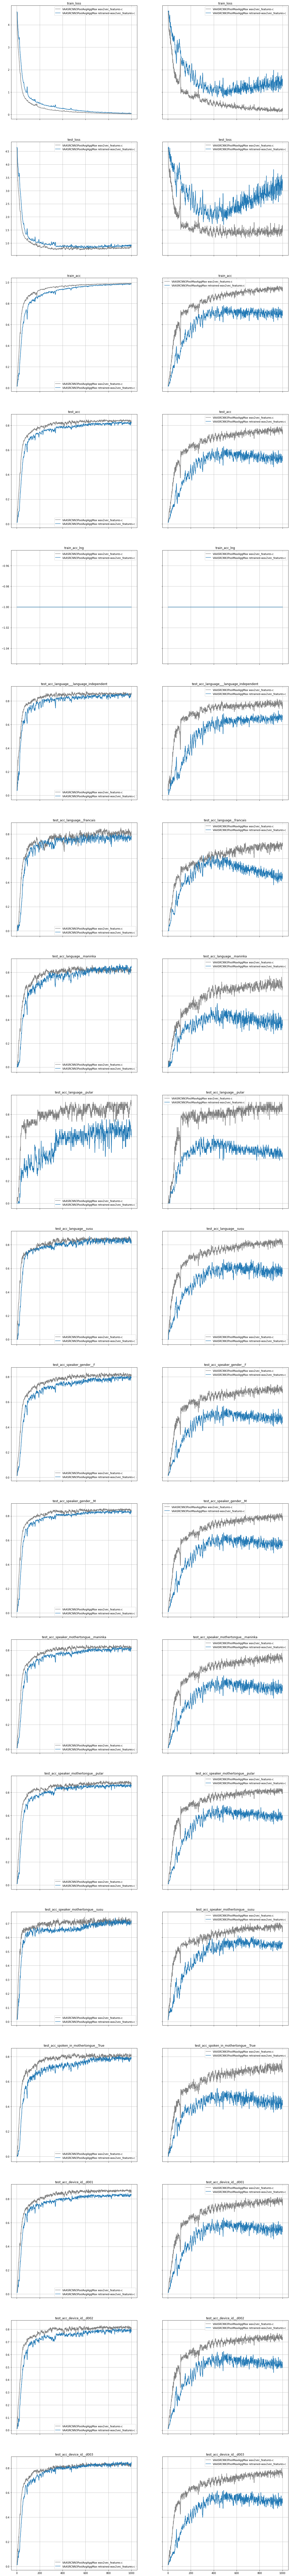

In [16]:
compared_features = ['wav2vec_features-c', 'retrained-wav2vec_features-c']
plot_results(model_names, plotted_variables, compared_features)

In [17]:
data_frames[model_name].keys()

dict_keys(['wav2vec_features-z_0', 'retrained-wav2vec_features-c_0', 'retrained-wav2vec_features-z_0', 'wav2vec_features-c_0'])

# Language Classification With Latent Features

fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold c

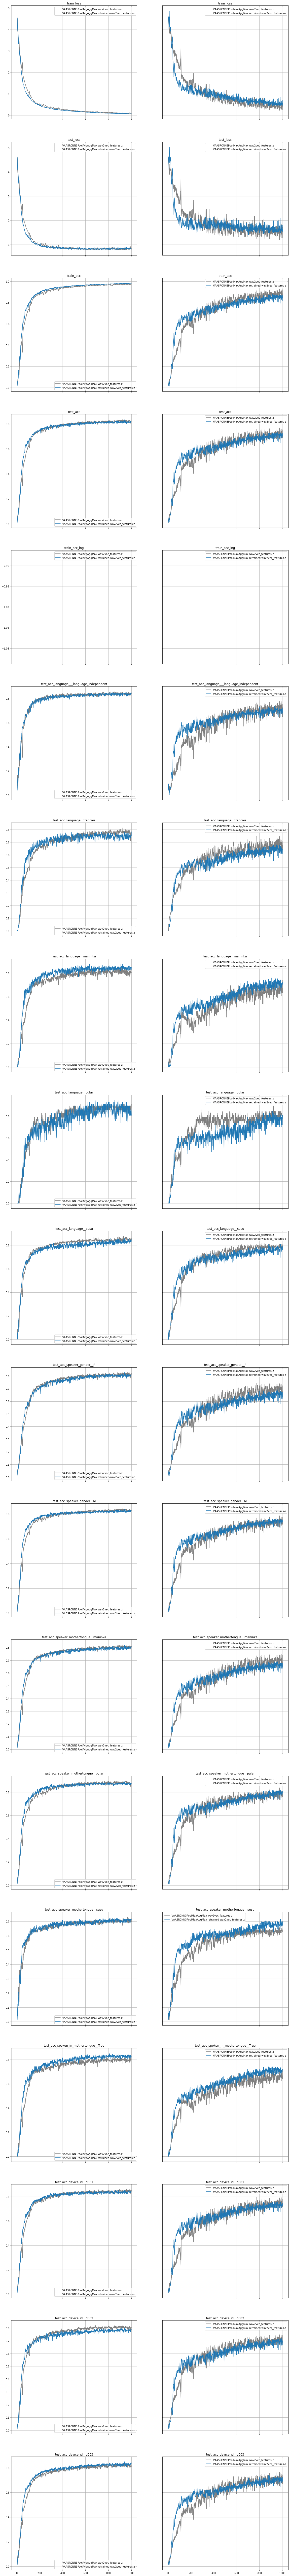

In [20]:
compared_features = ['wav2vec_features-z', 'retrained-wav2vec_features-z']
plot_results(model_names, plotted_variables, compared_features)

# Best epoch summaries

In [21]:
def make_label_str(model_name, feature_name):
    m_name = model_name.replace('LangId','')# .replace("1", "")

    f_name = feature_name.replace(
        "retrained-wav2vec_features-z", "OUR  Latent"
    ).replace(
        "retrained-wav2vec_features-c", "OUR  Context"
    ).replace(
        "wav2vec_features-z", "BSLN  Latent"
    ).replace(
        "wav2vec_features-c", "BSLN  Context"
    )


    # return m_name, f_name
    return f"{f_name} - {m_name}"

In [22]:
additional_plotted_summary_variables

['test_acc_language___language_independent',
 'test_acc_language__francais',
 'test_acc_language__maninka',
 'test_acc_language__pular',
 'test_acc_language__susu',
 'spacer',
 'test_acc_speaker_gender__F',
 'test_acc_speaker_gender__M',
 'spacer',
 'test_acc_speaker_mothertongue__maninka',
 'test_acc_speaker_mothertongue__pular',
 'test_acc_speaker_mothertongue__susu',
 'spacer',
 'test_acc_spoken_in_mothertongue__True',
 'spacer',
 'test_acc_device_id__d001',
 'test_acc_device_id__d002',
 'test_acc_device_id__d003']

In [23]:
def plot_summary_results(model_names, plotted_variables, compared_features):
    
    count_variables = [v.replace("test_acc_", "test_n_") for v in plotted_variables if v != "spacer"]
    requested_variables = list((set(plotted_variables + count_variables)))
    
    series_means = {v:[] for v in requested_variables}
    series_sems = {v:[] for v in requested_variables}
    series_mins = {v:[] for v in requested_variables}
    series_maxes = {v:[] for v in requested_variables}
    
    series_labels = {v:[] for v in requested_variables}
    fold_counts = []
    
    
    
    
    for variable in requested_variables:
        for feature_prefix in compared_features:
            
            for model_name in model_names:
                stats = get_variable_stats(model_name, feature_prefix, variable)
                series_means[variable].append(stats['best_epoch_mean'])
                series_sems[variable].append(stats['best_epoch_sem'])
                series_mins[variable].append(stats['best_epoch_min'])
                series_maxes[variable].append(stats['best_epoch_max'])
                series_labels[variable].append((model_name, feature_prefix))
                fold_counts.append(stats['fold_count'])
    
    # assert len(set(fold_counts)) == 1,  f"Inconsistent number of folds for model_names: {model_names}, features: {compared_features}: {fold_counts}"
    
    
    fold_count = fold_counts[0]
    
    for v in plotted_variables:
        df = pd.DataFrame(
            data={
                f'{v}_labels': [make_label_str(l[0], l[1]) for l in series_labels[v]],
                f'{v}_means': series_means[v],
                f'{v}_sems': series_sems[v],
            }
        )
        display(df)
    
    # Variables
    # 'train_loss', 'test_loss', 
    # 'train_acc', 'test_acc', 
    # 'test_acc_gender_male', 'test_acc_gender_female', 
    # 'test_acc_language_maninka', 'test_acc_language_pular', 'test_acc_language_susu'
    
    fig, ax = plt.subplots(figsize=(15, 18))
    #plt.bar(labels, mean_train_acc)
    #print(labels)
    bar_width = 5
    bar_margin = 21
    
    label_count = len(series_labels['test_acc'])
    
    colors = {
        "male": "#58508d",
        "female": "#ff6361",
        "maninka": "#88290d",
        "susu": "#b44f0f",
        "pular": "#dc790b",
        "train": "#7f7f7f",
        "test":"#4682b4"
    }

    
    #('test_acc_speaker_count_multiple', fold_count),
    #('test_acc_speaker_count_single', fold_count),
    
    
    #('test_acc_utterance_multilingual', fold_count),
    #('test_acc_utterance_verbal_nod', fold_count),
    
    
    #('test_acc_channel_music', fold_count),
    #('test_acc_channel_noise', fold_count),
    #('test_acc_channel_telephone', fold_count)
    

    train_y_pos = (bar_width+bar_margin)*np.arange(label_count)
    test_y_pos =(bar_width+bar_margin)*np.arange(label_count)
    y_bias = {}
    
    y_pos = 3
    for bias_variable in additional_plotted_summary_variables:
        if bias_variable == 'spacer':
            y_pos += .5
        else:
            y_pos += 1.1
            y_bias[bias_variable] = (bar_width+bar_margin)*np.arange(label_count) + y_pos

    ax.barh(train_y_pos, series_means['train_acc'], height=5, xerr=series_sems['train_acc'], color=colors['train'])
    ax.barh(test_y_pos, series_means['test_acc'], height=5, xerr=series_sems['test_acc'], color=colors['test']) # color=COLORS[2]
    
    bias_alpha = 0.6
    for bias_variable in additional_plotted_summary_variables:
        if bias_variable != 'spacer':
            ax.barh(y_bias[bias_variable], series_means[bias_variable], height=1, xerr=series_sems[bias_variable], color=colors['male'], alpha=bias_alpha)
        
        
    for i, label in enumerate(series_labels['test_acc']):
        (model_name, feature_name) = label

        
        
        label_str = make_label_str(model_name, feature_name)

        train_acc_label_str = f"{series_means['train_acc'][i]:.02%}"
        test_acc_label_str = f"{series_means['test_acc'][i]:.02%}"

        ax.text(0.01, train_y_pos[i], label_str, color='white', fontsize="x-large", fontweight="bold")

        ax.text(series_means['train_acc'][i]-0.07, train_y_pos[i]-0.7, train_acc_label_str, color='white', fontsize="large")
        ax.text(series_means['test_acc'][i]-0.07, train_y_pos[i]-0.7, test_acc_label_str, color='white', fontsize="large")
        

        for bias_variable in additional_plotted_summary_variables:
            if bias_variable != 'spacer':
                ax.barh(y_bias[bias_variable], series_means[bias_variable], height=1, xerr=series_sems[bias_variable], color=colors['male'], alpha=bias_alpha)
                bias_count_variable = bias_variable.replace("test_acc_", "test_n_")
                ax.text(0.01, y_bias[bias_variable][i]-0.3, f"{bias_variable} ({series_means[bias_count_variable][i]})", color='black', fontsize="small")

        
        ax.legend(["TRAIN", "TEST", "BIAS"])
        ax.set_xlim(0, 1)
        ax.get_yaxis().set_ticks([])
        ax.set_title(f"Average and SEM (n={fold_count} folds) Speech Recognition Accuracies. Conv Dropout p={CONV_DROPOUT_P}. FC Dropout p={FC_DROPOUT_P}")
        ax.grid(True)

        

fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1


train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Latent - VAASRCNN3PoolAvgAggMax          0.108505              0.0
1   OUR  Latent - VAASRCNN3PoolAvgAggMax          0.078178              0.0

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Latent - VAASRCNN3PoolAvgAggMax         0.775180             0.0
1   OUR  Latent - VAASRCNN3PoolAvgAggMax         0.786887             0.0

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Latent - VAASRCNN3PoolAvgAggMax         0.973081             0.0
1   OUR  Latent - VAASRCNN3PoolAvgAggMax         0.980392             0.0

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Latent - VAASRCNN3PoolAvgAggMax        0.837981            0.0
1   OUR  Latent - VAASRCNN3PoolAvgAggMax        0.833997            0.0

train_acc_lng_labels  train_acc_lng_means  \
0  BSLN  Latent - VAASRCNN3PoolAvgAggMax                 -1.0   
1   OUR  Latent - VAASRCNN3PoolAvgAggMax                 -1.0   

   train_acc_lng_sems  
0                 0.0  
1                 0.0

test_acc_language___language_independent_labels  \
0           BSLN  Latent - VAASRCNN3PoolAvgAggMax   
1            OUR  Latent - VAASRCNN3PoolAvgAggMax   

   test_acc_language___language_independent_means  \
0                                        0.848214   
1                                        0.846726   

   test_acc_language___language_independent_sems  
0                                            0.0  
1                                            0.0

test_acc_language__francais_labels  test_acc_language__francais_means  \
0  BSLN  Latent - VAASRCNN3PoolAvgAggMax                           0.814176   
1   OUR  Latent - VAASRCNN3PoolAvgAggMax                           0.781609   

   test_acc_language__francais_sems  
0                               0.0  
1                               0.0

test_acc_language__maninka_labels  test_acc_language__maninka_means  \
0  BSLN  Latent - VAASRCNN3PoolAvgAggMax                          0.820707   
1   OUR  Latent - VAASRCNN3PoolAvgAggMax                          0.843434   

   test_acc_language__maninka_sems  
0                              0.0  
1                              0.0

test_acc_language__pular_labels  test_acc_language__pular_means  \
0  BSLN  Latent - VAASRCNN3PoolAvgAggMax                        0.859649   
1   OUR  Latent - VAASRCNN3PoolAvgAggMax                        0.859649   

   test_acc_language__pular_sems  
0                            0.0  
1                            0.0

test_acc_language__susu_labels  test_acc_language__susu_means  \
0  BSLN  Latent - VAASRCNN3PoolAvgAggMax                       0.856209   
1   OUR  Latent - VAASRCNN3PoolAvgAggMax                       0.856209   

   test_acc_language__susu_sems  
0                           0.0  
1                           0.0

test_acc_speaker_gender__F_labels  test_acc_speaker_gender__F_means  \
0  BSLN  Latent - VAASRCNN3PoolAvgAggMax                          0.828431   
1   OUR  Latent - VAASRCNN3PoolAvgAggMax                          0.827206   

   test_acc_speaker_gender__F_sems  
0                              0.0  
1                              0.0

test_acc_speaker_gender__M_labels  test_acc_speaker_gender__M_means  \
0  BSLN  Latent - VAASRCNN3PoolAvgAggMax                          0.843382   
1   OUR  Latent - VAASRCNN3PoolAvgAggMax                          0.837838   

   test_acc_speaker_gender__M_sems  
0                              0.0  
1                              0.0

test_acc_speaker_mothertongue__maninka_labels  \
0         BSLN  Latent - VAASRCNN3PoolAvgAggMax   
1          OUR  Latent - VAASRCNN3PoolAvgAggMax   

   test_acc_speaker_mothertongue__maninka_means  \
0                                      0.822379   
1                                      0.817684   

   test_acc_speaker_mothertongue__maninka_sems  
0                                          0.0  
1                                          0.0

test_acc_speaker_mothertongue__pular_labels  \
0       BSLN  Latent - VAASRCNN3PoolAvgAggMax   
1        OUR  Latent - VAASRCNN3PoolAvgAggMax   

   test_acc_speaker_mothertongue__pular_means  \
0                                    0.893939   
1                                    0.888889   

   test_acc_speaker_mothertongue__pular_sems  
0                                        0.0  
1                                        0.0

test_acc_speaker_mothertongue__susu_labels  \
0      BSLN  Latent - VAASRCNN3PoolAvgAggMax   
1       OUR  Latent - VAASRCNN3PoolAvgAggMax   

   test_acc_speaker_mothertongue__susu_means  \
0                                   0.708995   
1                                   0.714286   

   test_acc_speaker_mothertongue__susu_sems  
0                                       0.0  
1                                       0.0

test_acc_spoken_in_mothertongue__True_labels  \
0        BSLN  Latent - VAASRCNN3PoolAvgAggMax   
1         OUR  Latent - VAASRCNN3PoolAvgAggMax   

   test_acc_spoken_in_mothertongue__True_means  \
0                                     0.796909   
1                                     0.823400   

   test_acc_spoken_in_mothertongue__True_sems  
0                                         0.0  
1                                         0.0

test_acc_device_id__d001_labels  test_acc_device_id__d001_means  \
0  BSLN  Latent - VAASRCNN3PoolAvgAggMax                        0.855246   
1   OUR  Latent - VAASRCNN3PoolAvgAggMax                        0.852590   

   test_acc_device_id__d001_sems  
0                            0.0  
1                            0.0

test_acc_device_id__d002_labels  test_acc_device_id__d002_means  \
0  BSLN  Latent - VAASRCNN3PoolAvgAggMax                        0.819389   
1   OUR  Latent - VAASRCNN3PoolAvgAggMax                        0.799469   

   test_acc_device_id__d002_sems  
0                            0.0  
1                            0.0

test_acc_device_id__d003_labels  test_acc_device_id__d003_means  \
0  BSLN  Latent - VAASRCNN3PoolAvgAggMax                        0.839309   
1   OUR  Latent - VAASRCNN3PoolAvgAggMax                        0.849934   

   test_acc_device_id__d003_sems  
0                            0.0  
1                            0.0

fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1


train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Context - VAASRCNN3PoolAvgAggMax          0.054684              0.0
1   OUR  Context - VAASRCNN3PoolAvgAggMax          0.074670              0.0

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Context - VAASRCNN3PoolAvgAggMax         0.768723             0.0
1   OUR  Context - VAASRCNN3PoolAvgAggMax         0.856885             0.0

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Context - VAASRCNN3PoolAvgAggMax         0.986374             0.0
1   OUR  Context - VAASRCNN3PoolAvgAggMax         0.980558             0.0

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Context - VAASRCNN3PoolAvgAggMax        0.849934            0.0
1   OUR  Context - VAASRCNN3PoolAvgAggMax        0.830899            0.0

train_acc_lng_labels  train_acc_lng_means  \
0  BSLN  Context - VAASRCNN3PoolAvgAggMax                 -1.0   
1   OUR  Context - VAASRCNN3PoolAvgAggMax                 -1.0   

   train_acc_lng_sems  
0                 0.0  
1                 0.0

test_acc_language___language_independent_labels  \
0          BSLN  Context - VAASRCNN3PoolAvgAggMax   
1           OUR  Context - VAASRCNN3PoolAvgAggMax   

   test_acc_language___language_independent_means  \
0                                        0.869048   
1                                        0.854167   

   test_acc_language___language_independent_sems  
0                                            0.0  
1                                            0.0

test_acc_language__francais_labels  test_acc_language__francais_means  \
0  BSLN  Context - VAASRCNN3PoolAvgAggMax                           0.846743   
1   OUR  Context - VAASRCNN3PoolAvgAggMax                           0.798851   

   test_acc_language__francais_sems  
0                               0.0  
1                               0.0

test_acc_language__maninka_labels  test_acc_language__maninka_means  \
0  BSLN  Context - VAASRCNN3PoolAvgAggMax                          0.813131   
1   OUR  Context - VAASRCNN3PoolAvgAggMax                          0.828283   

   test_acc_language__maninka_sems  
0                              0.0  
1                              0.0

test_acc_language__pular_labels  test_acc_language__pular_means  \
0  BSLN  Context - VAASRCNN3PoolAvgAggMax                        0.842105   
1   OUR  Context - VAASRCNN3PoolAvgAggMax                        0.596491   

   test_acc_language__pular_sems  
0                            0.0  
1                            0.0

test_acc_language__susu_labels  test_acc_language__susu_means  \
0  BSLN  Context - VAASRCNN3PoolAvgAggMax                       0.856209   
1   OUR  Context - VAASRCNN3PoolAvgAggMax                       0.856209   

   test_acc_language__susu_sems  
0                           0.0  
1                           0.0

test_acc_speaker_gender__F_labels  test_acc_speaker_gender__F_means  \
0  BSLN  Context - VAASRCNN3PoolAvgAggMax                          0.830882   
1   OUR  Context - VAASRCNN3PoolAvgAggMax                          0.801471   

   test_acc_speaker_gender__F_sems  
0                              0.0  
1                              0.0

test_acc_speaker_gender__M_labels  test_acc_speaker_gender__M_means  \
0  BSLN  Context - VAASRCNN3PoolAvgAggMax                          0.860707   
1   OUR  Context - VAASRCNN3PoolAvgAggMax                          0.847540   

   test_acc_speaker_gender__M_sems  
0                              0.0  
1                              0.0

test_acc_speaker_mothertongue__maninka_labels  \
0        BSLN  Context - VAASRCNN3PoolAvgAggMax   
1         OUR  Context - VAASRCNN3PoolAvgAggMax   

   test_acc_speaker_mothertongue__maninka_means  \
0                                      0.841941   
1                                      0.827074   

   test_acc_speaker_mothertongue__maninka_sems  
0                                          0.0  
1                                          0.0

test_acc_speaker_mothertongue__pular_labels  \
0      BSLN  Context - VAASRCNN3PoolAvgAggMax   
1       OUR  Context - VAASRCNN3PoolAvgAggMax   

   test_acc_speaker_mothertongue__pular_means  \
0                                    0.891414   
1                                    0.858586   

   test_acc_speaker_mothertongue__pular_sems  
0                                        0.0  
1                                        0.0

test_acc_speaker_mothertongue__susu_labels  \
0     BSLN  Context - VAASRCNN3PoolAvgAggMax   
1      OUR  Context - VAASRCNN3PoolAvgAggMax   

   test_acc_speaker_mothertongue__susu_means  \
0                                   0.730159   
1                                   0.740741   

   test_acc_speaker_mothertongue__susu_sems  
0                                       0.0  
1                                       0.0

test_acc_spoken_in_mothertongue__True_labels  \
0       BSLN  Context - VAASRCNN3PoolAvgAggMax   
1        OUR  Context - VAASRCNN3PoolAvgAggMax   

   test_acc_spoken_in_mothertongue__True_means  \
0                                     0.807947   
1                                     0.794702   

   test_acc_spoken_in_mothertongue__True_sems  
0                                         0.0  
1                                         0.0

test_acc_device_id__d001_labels  test_acc_device_id__d001_means  \
0  BSLN  Context - VAASRCNN3PoolAvgAggMax                        0.876494   
1   OUR  Context - VAASRCNN3PoolAvgAggMax                        0.840637   

   test_acc_device_id__d001_sems  
0                            0.0  
1                            0.0

test_acc_device_id__d002_labels  test_acc_device_id__d002_means  \
0  BSLN  Context - VAASRCNN3PoolAvgAggMax                        0.826029   
1   OUR  Context - VAASRCNN3PoolAvgAggMax                        0.804781   

   test_acc_device_id__d002_sems  
0                            0.0  
1                            0.0

test_acc_device_id__d003_labels  test_acc_device_id__d003_means  \
0  BSLN  Context - VAASRCNN3PoolAvgAggMax                        0.847278   
1   OUR  Context - VAASRCNN3PoolAvgAggMax                        0.847278   

   test_acc_device_id__d003_sems  
0                            0.0  
1                            0.0

fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1


train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Latent - VAASRCNN3PoolMaxAggMax          0.233503              0.0
1   OUR  Latent - VAASRCNN3PoolMaxAggMax          0.430609              0.0

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Latent - VAASRCNN3PoolMaxAggMax         1.199652             0.0
1   OUR  Latent - VAASRCNN3PoolMaxAggMax         1.466771             0.0

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Latent - VAASRCNN3PoolMaxAggMax         0.927883             0.0
1   OUR  Latent - VAASRCNN3PoolMaxAggMax         0.878531             0.0

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Latent - VAASRCNN3PoolMaxAggMax        0.768482            0.0
1   OUR  Latent - VAASRCNN3PoolMaxAggMax        0.739708            0.0

train_acc_lng_labels  train_acc_lng_means  \
0  BSLN  Latent - VAASRCNN3PoolMaxAggMax                 -1.0   
1   OUR  Latent - VAASRCNN3PoolMaxAggMax                 -1.0   

   train_acc_lng_sems  
0                 0.0  
1                 0.0

test_acc_language___language_independent_labels  \
0           BSLN  Latent - VAASRCNN3PoolMaxAggMax   
1            OUR  Latent - VAASRCNN3PoolMaxAggMax   

   test_acc_language___language_independent_means  \
0                                        0.776786   
1                                        0.738095   

   test_acc_language___language_independent_sems  
0                                            0.0  
1                                            0.0

test_acc_language__francais_labels  test_acc_language__francais_means  \
0  BSLN  Latent - VAASRCNN3PoolMaxAggMax                           0.745211   
1   OUR  Latent - VAASRCNN3PoolMaxAggMax                           0.689655   

   test_acc_language__francais_sems  
0                               0.0  
1                               0.0

test_acc_language__maninka_labels  test_acc_language__maninka_means  \
0  BSLN  Latent - VAASRCNN3PoolMaxAggMax                          0.719697   
1   OUR  Latent - VAASRCNN3PoolMaxAggMax                          0.727273   

   test_acc_language__maninka_sems  
0                              0.0  
1                              0.0

test_acc_language__pular_labels  test_acc_language__pular_means  \
0  BSLN  Latent - VAASRCNN3PoolMaxAggMax                        0.807018   
1   OUR  Latent - VAASRCNN3PoolMaxAggMax                        0.771930   

   test_acc_language__pular_sems  
0                            0.0  
1                            0.0

test_acc_language__susu_labels  test_acc_language__susu_means  \
0  BSLN  Latent - VAASRCNN3PoolMaxAggMax                       0.807190   
1   OUR  Latent - VAASRCNN3PoolMaxAggMax                       0.789216   

   test_acc_language__susu_sems  
0                           0.0  
1                           0.0

test_acc_speaker_gender__F_labels  test_acc_speaker_gender__F_means  \
0  BSLN  Latent - VAASRCNN3PoolMaxAggMax                          0.738971   
1   OUR  Latent - VAASRCNN3PoolMaxAggMax                          0.700980   

   test_acc_speaker_gender__F_sems  
0                              0.0  
1                              0.0

test_acc_speaker_gender__M_labels  test_acc_speaker_gender__M_means  \
0  BSLN  Latent - VAASRCNN3PoolMaxAggMax                          0.785170   
1   OUR  Latent - VAASRCNN3PoolMaxAggMax                          0.761608   

   test_acc_speaker_gender__M_sems  
0                              0.0  
1                              0.0

test_acc_speaker_mothertongue__maninka_labels  \
0         BSLN  Latent - VAASRCNN3PoolMaxAggMax   
1          OUR  Latent - VAASRCNN3PoolMaxAggMax   

   test_acc_speaker_mothertongue__maninka_means  \
0                                      0.742567   
1                                      0.697183   

   test_acc_speaker_mothertongue__maninka_sems  
0                                          0.0  
1                                          0.0

test_acc_speaker_mothertongue__pular_labels  \
0       BSLN  Latent - VAASRCNN3PoolMaxAggMax   
1        OUR  Latent - VAASRCNN3PoolMaxAggMax   

   test_acc_speaker_mothertongue__pular_means  \
0                                    0.837121   
1                                    0.819444   

   test_acc_speaker_mothertongue__pular_sems  
0                                        0.0  
1                                        0.0

test_acc_speaker_mothertongue__susu_labels  \
0      BSLN  Latent - VAASRCNN3PoolMaxAggMax   
1       OUR  Latent - VAASRCNN3PoolMaxAggMax   

   test_acc_speaker_mothertongue__susu_means  \
0                                   0.656085   
1                                   0.693122   

   test_acc_speaker_mothertongue__susu_sems  
0                                       0.0  
1                                       0.0

test_acc_spoken_in_mothertongue__True_labels  \
0        BSLN  Latent - VAASRCNN3PoolMaxAggMax   
1         OUR  Latent - VAASRCNN3PoolMaxAggMax   

   test_acc_spoken_in_mothertongue__True_means  \
0                                     0.706402   
1                                     0.724062   

   test_acc_spoken_in_mothertongue__True_sems  
0                                         0.0  
1                                         0.0

test_acc_device_id__d001_labels  test_acc_device_id__d001_means  \
0  BSLN  Latent - VAASRCNN3PoolMaxAggMax                        0.791501   
1   OUR  Latent - VAASRCNN3PoolMaxAggMax                        0.754316   

   test_acc_device_id__d001_sems  
0                            0.0  
1                            0.0

test_acc_device_id__d002_labels  test_acc_device_id__d002_means  \
0  BSLN  Latent - VAASRCNN3PoolMaxAggMax                        0.747676   
1   OUR  Latent - VAASRCNN3PoolMaxAggMax                        0.717131   

   test_acc_device_id__d002_sems  
0                            0.0  
1                            0.0

test_acc_device_id__d003_labels  test_acc_device_id__d003_means  \
0  BSLN  Latent - VAASRCNN3PoolMaxAggMax                        0.766268   
1   OUR  Latent - VAASRCNN3PoolMaxAggMax                        0.747676   

   test_acc_device_id__d003_sems  
0                            0.0  
1                            0.0

fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1
fold count: 1


train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Context - VAASRCNN3PoolMaxAggMax          0.133730              0.0
1   OUR  Context - VAASRCNN3PoolMaxAggMax          0.742148              0.0

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Context - VAASRCNN3PoolMaxAggMax         1.243594             0.0
1   OUR  Context - VAASRCNN3PoolMaxAggMax         1.705325             0.0

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Context - VAASRCNN3PoolMaxAggMax         0.958126             0.0
1   OUR  Context - VAASRCNN3PoolMaxAggMax         0.781821             0.0

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Context - VAASRCNN3PoolMaxAggMax        0.789730            0.0
1   OUR  Context - VAASRCNN3PoolMaxAggMax        0.628597            0.0

train_acc_lng_labels  train_acc_lng_means  \
0  BSLN  Context - VAASRCNN3PoolMaxAggMax                 -1.0   
1   OUR  Context - VAASRCNN3PoolMaxAggMax                 -1.0   

   train_acc_lng_sems  
0                 0.0  
1                 0.0

test_acc_language___language_independent_labels  \
0          BSLN  Context - VAASRCNN3PoolMaxAggMax   
1           OUR  Context - VAASRCNN3PoolMaxAggMax   

   test_acc_language___language_independent_means  \
0                                        0.808036   
1                                        0.693452   

   test_acc_language___language_independent_sems  
0                                            0.0  
1                                            0.0

test_acc_language__francais_labels  test_acc_language__francais_means  \
0  BSLN  Context - VAASRCNN3PoolMaxAggMax                           0.731801   
1   OUR  Context - VAASRCNN3PoolMaxAggMax                           0.603448   

   test_acc_language__francais_sems  
0                               0.0  
1                               0.0

test_acc_language__maninka_labels  test_acc_language__maninka_means  \
0  BSLN  Context - VAASRCNN3PoolMaxAggMax                          0.747475   
1   OUR  Context - VAASRCNN3PoolMaxAggMax                          0.494949   

   test_acc_language__maninka_sems  
0                              0.0  
1                              0.0

test_acc_language__pular_labels  test_acc_language__pular_means  \
0  BSLN  Context - VAASRCNN3PoolMaxAggMax                        0.842105   
1   OUR  Context - VAASRCNN3PoolMaxAggMax                        0.508772   

   test_acc_language__pular_sems  
0                            0.0  
1                            0.0

test_acc_language__susu_labels  test_acc_language__susu_means  \
0  BSLN  Context - VAASRCNN3PoolMaxAggMax                       0.841503   
1   OUR  Context - VAASRCNN3PoolMaxAggMax                       0.676471   

   test_acc_language__susu_sems  
0                           0.0  
1                           0.0

test_acc_speaker_gender__F_labels  test_acc_speaker_gender__F_means  \
0  BSLN  Context - VAASRCNN3PoolMaxAggMax                          0.740196   
1   OUR  Context - VAASRCNN3PoolMaxAggMax                          0.568627   

   test_acc_speaker_gender__F_sems  
0                              0.0  
1                              0.0

test_acc_speaker_gender__M_labels  test_acc_speaker_gender__M_means  \
0  BSLN  Context - VAASRCNN3PoolMaxAggMax                          0.817741   
1   OUR  Context - VAASRCNN3PoolMaxAggMax                          0.662509   

   test_acc_speaker_gender__M_sems  
0                              0.0  
1                              0.0

test_acc_speaker_mothertongue__maninka_labels  \
0        BSLN  Context - VAASRCNN3PoolMaxAggMax   
1         OUR  Context - VAASRCNN3PoolMaxAggMax   

   test_acc_speaker_mothertongue__maninka_means  \
0                                      0.776995   
1                                      0.595462   

   test_acc_speaker_mothertongue__maninka_sems  
0                                          0.0  
1                                          0.0

test_acc_speaker_mothertongue__pular_labels  \
0      BSLN  Context - VAASRCNN3PoolMaxAggMax   
1       OUR  Context - VAASRCNN3PoolMaxAggMax   

   test_acc_speaker_mothertongue__pular_means  \
0                                    0.837121   
1                                    0.691919   

   test_acc_speaker_mothertongue__pular_sems  
0                                        0.0  
1                                        0.0

test_acc_speaker_mothertongue__susu_labels  \
0     BSLN  Context - VAASRCNN3PoolMaxAggMax   
1      OUR  Context - VAASRCNN3PoolMaxAggMax   

   test_acc_speaker_mothertongue__susu_means  \
0                                   0.677249   
1                                   0.587302   

   test_acc_speaker_mothertongue__susu_sems  
0                                       0.0  
1                                       0.0

test_acc_spoken_in_mothertongue__True_labels  \
0       BSLN  Context - VAASRCNN3PoolMaxAggMax   
1        OUR  Context - VAASRCNN3PoolMaxAggMax   

   test_acc_spoken_in_mothertongue__True_means  \
0                                     0.743929   
1                                     0.523179   

   test_acc_spoken_in_mothertongue__True_sems  
0                                         0.0  
1                                         0.0

test_acc_device_id__d001_labels  test_acc_device_id__d001_means  \
0  BSLN  Context - VAASRCNN3PoolMaxAggMax                        0.815405   
1   OUR  Context - VAASRCNN3PoolMaxAggMax                        0.641434   

   test_acc_device_id__d001_sems  
0                            0.0  
1                            0.0

test_acc_device_id__d002_labels  test_acc_device_id__d002_means  \
0  BSLN  Context - VAASRCNN3PoolMaxAggMax                        0.768924   
1   OUR  Context - VAASRCNN3PoolMaxAggMax                        0.625498   

   test_acc_device_id__d002_sems  
0                            0.0  
1                            0.0

test_acc_device_id__d003_labels  test_acc_device_id__d003_means  \
0  BSLN  Context - VAASRCNN3PoolMaxAggMax                        0.784861   
1   OUR  Context - VAASRCNN3PoolMaxAggMax                        0.618858   

   test_acc_device_id__d003_sems  
0                            0.0  
1                            0.0

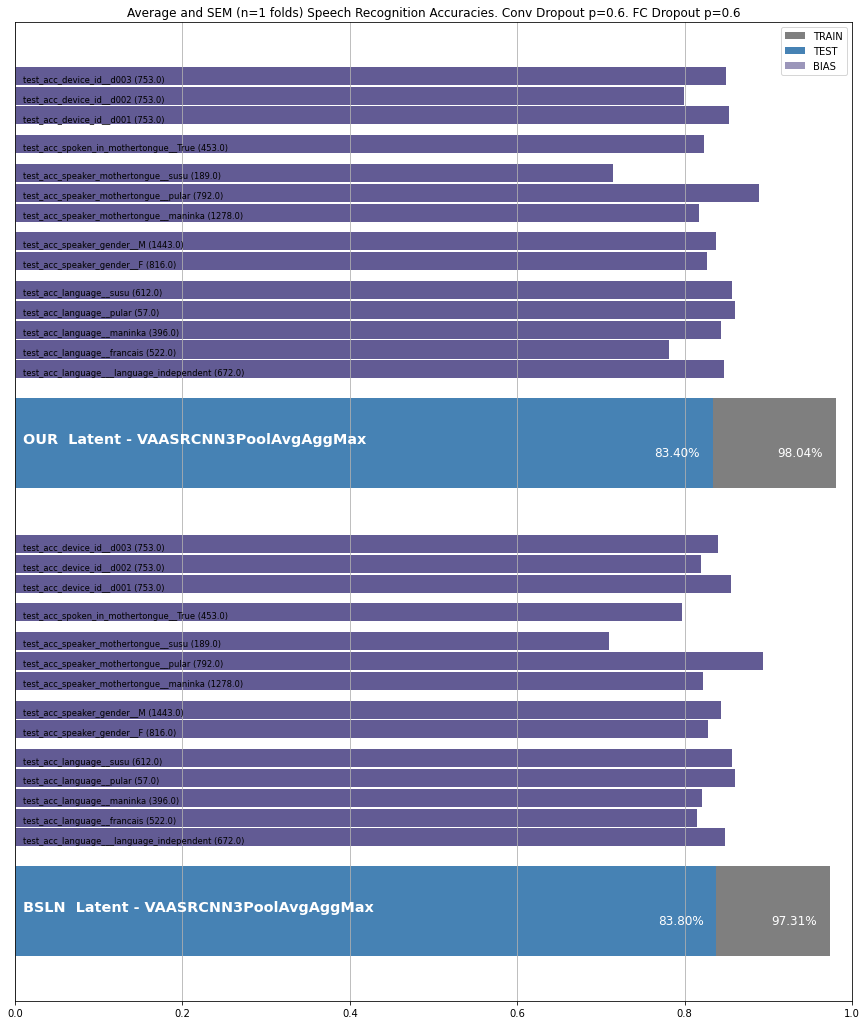

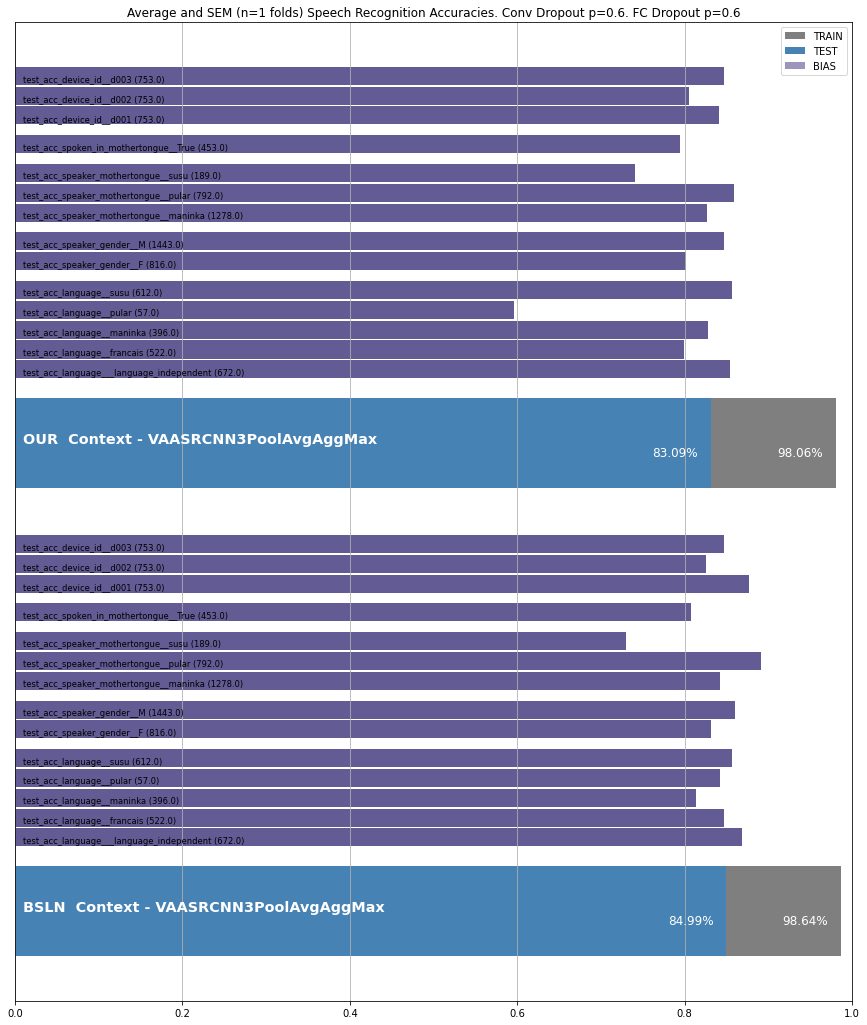

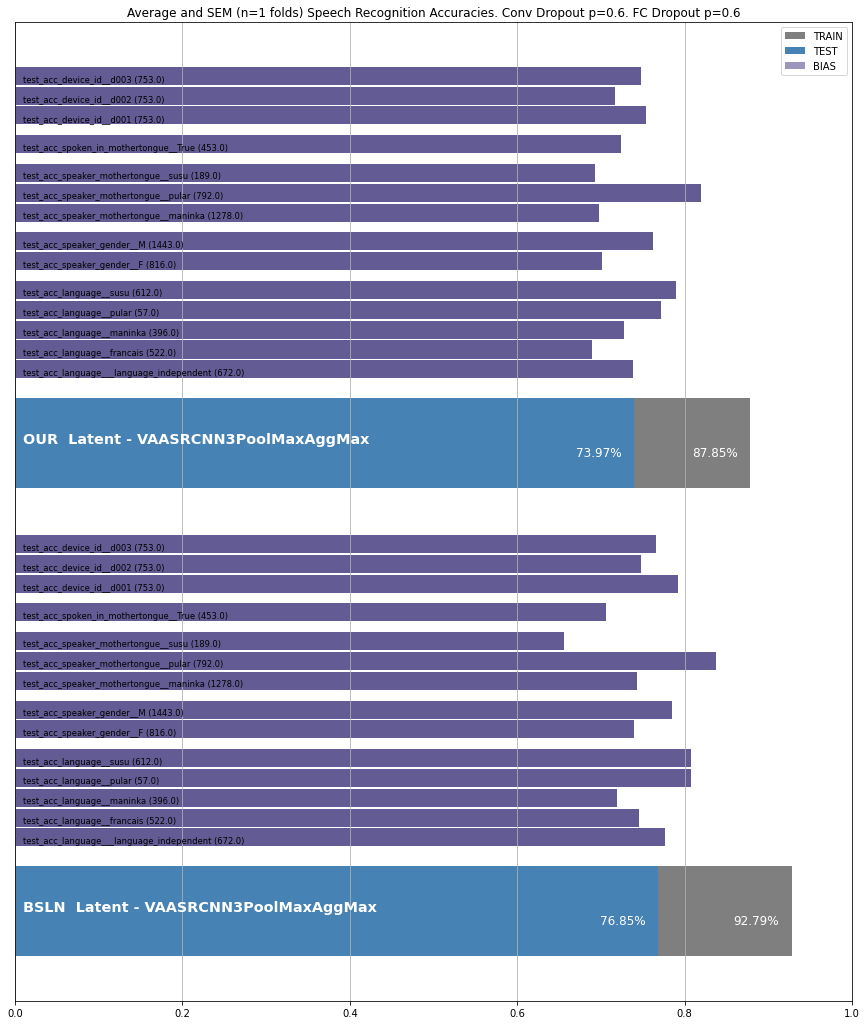

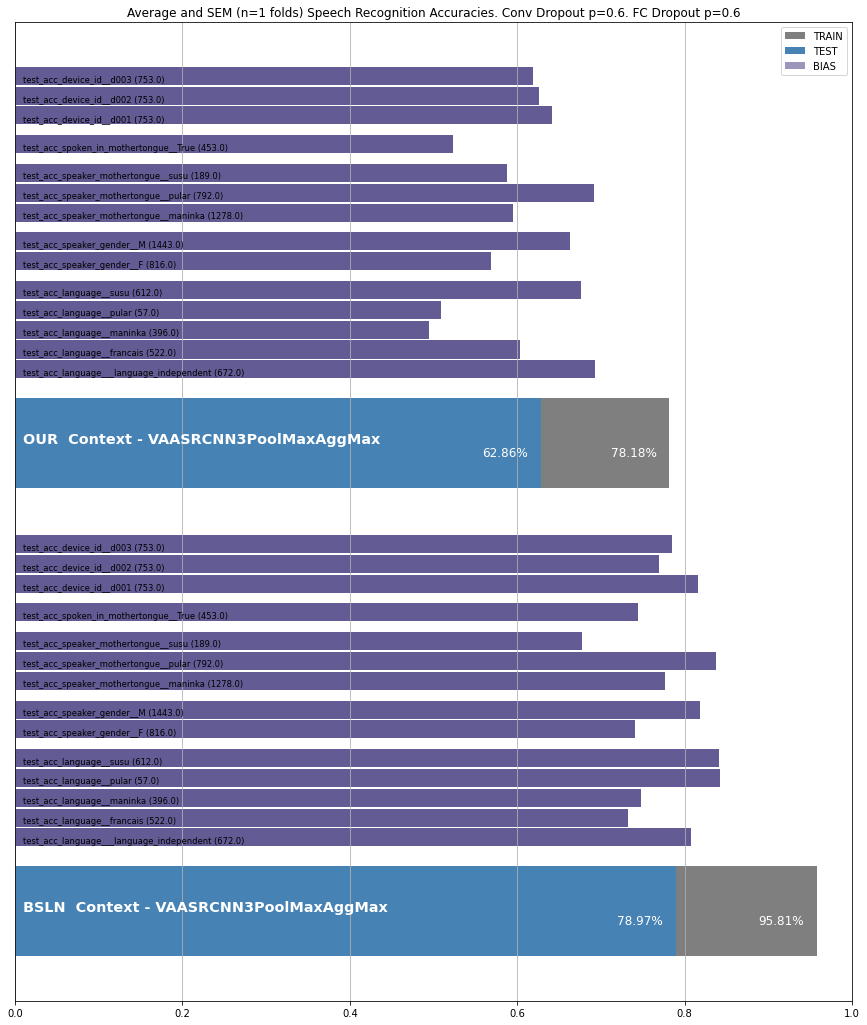

In [25]:
compared_features_latent = ['wav2vec_features-z', 'retrained-wav2vec_features-z']
compared_features_ctx = ['wav2vec_features-c', 'retrained-wav2vec_features-c']

for model_name in model_names:
    plot_summary_results([model_name], plotted_variables, compared_features_latent)
    plot_summary_results([model_name], plotted_variables, compared_features_ctx)
